# Análisis de datos exploratorio

## Cargar datos

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
def load_data():
    !curl -L "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/945z9xkc8d-1.zip" -o data.zip
    !unzip "data.zip" && unzip "Fake News Dataset.zip"
    !rm -r *.zip

    main_directory = os.path.join(os.getcwd(),"Fake News Dataset")
    subdirectories = [x[0] for x in os.walk(main_directory)][1:]
    print(main_directory)
    dataframes = []
    test = []
    # Itera a través de los subdirectorios y archivos train.csv
    for subdirectory in subdirectories:
        file_path = os.path.join(subdirectory, "train.csv")
        test_path = os.path.join(subdirectory, "test.csv")

        # Verifica si el archivo train.csv existe en el subdirectorio
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            dataframes.append(data)

        if os.path.exists(test_path):
            data = pd.read_csv(test_path)
            test.append(data)

    # Combina los DataFrames en uno solo
    combined_data = pd.concat(dataframes, ignore_index=True)
    test_data = pd.concat(test,ignore_index=True)

    # Guarda el DataFrame combinado en un archivo train_combined.csv
    combined_data.to_csv("dataset.csv", index=False)
    test_data.to_csv("test.csv", index=False)
    print("Archivos train.csv combinados con éxito en train_combined.csv")

In [3]:
try:
    df = pd.read_csv("dataset.csv",sep=";")
    test = pd.read_parquet("0.parquet")

except:
    print("Downloading dataset .....")
    load_data()
    !curl -L "https://huggingface.co/datasets/GonzaloA/fake_news/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet" -o 0.parquet
    test = pd.read_parquet("0.parquet")
    df = pd.read_csv("dataset.csv",sep=";")
    #test = pd.read_csv("test.csv",sep=";")

## Inspeccionar datos

In [4]:
df.head(5)

,text,label
0,complete sentence exploration orin langelle vo...,0
1,ten thousand people get fooled fake ballot wit...,0
2,comment sweep election first thing trump invit...,0
3,astonish chart show moderate republican endang...,1
4,clinton ekes win iowa sander kill obama admini...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61590 entries, 0 to 61589
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    61590 non-null  object
 1   label   61590 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 962.5+ KB


# Visualizacion del Dataset

## Dataset Balanceado

Text(-12.430555555555555, 0.5, 'Conteo')

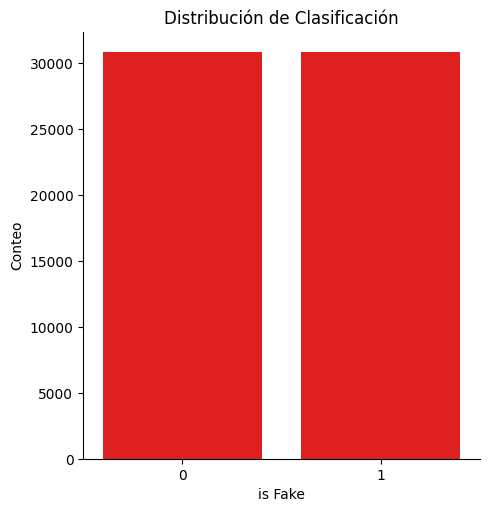

In [6]:
## Librerias para graficación
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizamos si la data esta balanceada
sns.catplot(x="label", kind="count", color="r", data=df)
plt.title("Distribución de Clasificación")
plt.xlabel("is Fake")
plt.ylabel("Conteo")

## Word Cloud de los titulares de las *Fake News*

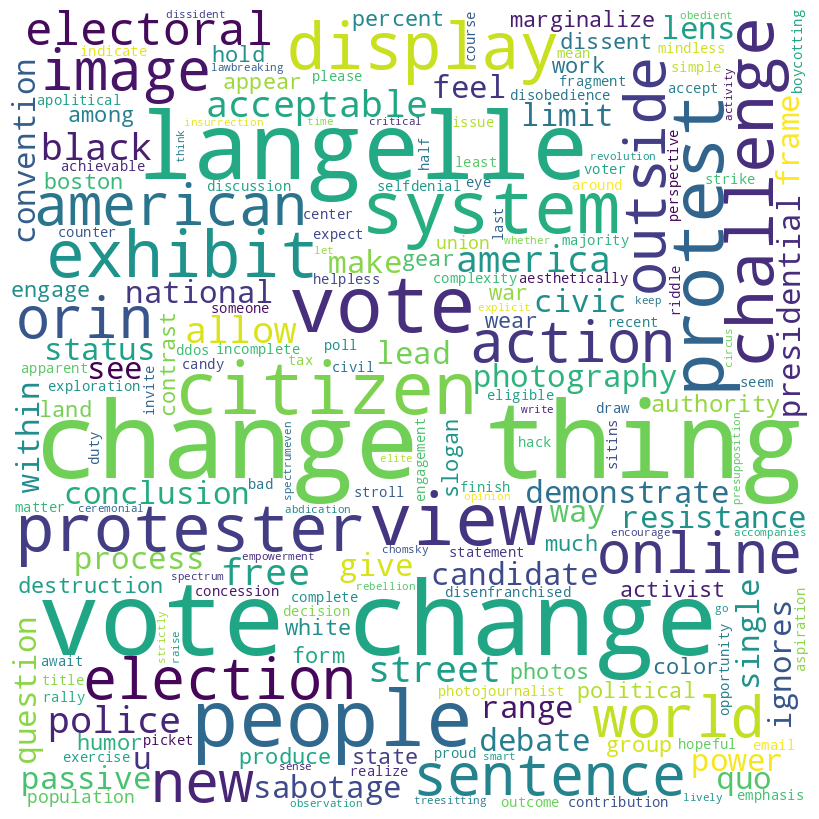

In [7]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS

comment_words = ""
stopwords = set(STOPWORDS)

# Recorrer el dataframe
for val in df["text"][0:1]:
    # Castear cada palabra a string
    val = str(val)

    # Separamos por palabra
    tokens = val.split()

    # Pasamos a minusculas
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(comment_words)

# Generamos el plot
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Pre-Procesado de los datos para NLP

In [8]:
df["features"] = df["text"]
test["features"] = test["text"] + test["title"]

## 2. Tokenization

In [9]:
# importamos word_tokenize desde nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
# Pasar el texto de la cadena a la palabra tokenize para romper las oraciones
df["features"] = df["features"].apply(lambda x: word_tokenize(x))
test["features"] = test["features"].apply(lambda x: word_tokenize(x))

In [11]:
df["features"].head()

0    [complete, sentence, exploration, orin, langel...
1    [ten, thousand, people, get, fooled, fake, bal...
2    [comment, sweep, election, first, thing, trump...
3    [astonish, chart, show, moderate, republican, ...
4    [clinton, ekes, win, iowa, sander, kill, obama...
Name: features, dtype: object

In [12]:
print(FreqDist(df["features"][:1].to_list()[0]).most_common)

<bound method Counter.most_common of FreqDist({'vote': 17, 'change': 13, 'thing': 12, 'langelle': 9, 'people': 6, 'view': 5, 'citizen': 5, 'protest': 5, 'system': 5, 'exhibit': 4, ...})>


## 3. Lemmatization

In [13]:
import nltk
nltk.download('wordnet')
lemmer = nltk.stem.WordNetLemmatizer()

df["features"] = df["features"].apply(lambda x: [lemmer.lemmatize(y) for y in x])
test["features"] = test["features"].apply(lambda x: [lemmer.lemmatize(y) for y in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 4. StopWords

In [14]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# debemos indicar que la oracion se encuentra en ingles
a = set(stopwords.words("english"))

# convertimos el texto a minusculas
df["features"] = df["features"].apply(lambda x: [y.lower() for y in x])
# Eliminamos las stop words del dataset
df["features"] = df["features"].apply(lambda x: [y for y in x if y not in a])
# convertimos el texto a minusculas
test["features"] = test["features"].apply(lambda x: [y.lower() for y in x])
# Eliminamos las stop words del dataset
test["features"] = test["features"].apply(lambda x: [y for y in x if y not in a])

## Creacion de la representacion del texto (Word2Vec, Keras Embedding, BOW)

In [16]:
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [30]:
max_words = 10000
max_sequence_length = 250

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test["features"])

X_sequences = tokenizer.texts_to_sequences(
    df["features"]
)  # Convertir texto a secuencia de números

X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

Y_sequences = tokenizer.texts_to_sequences(
    test["features"]
)  # Convertir texto a secuencia de números

Y_padded = pad_sequences(Y_sequences, maxlen=max_sequence_length)

In [35]:
X_train, y_train = Y_padded, test["label"]
X_test, y_test = X_padded, df["label"]

In [31]:
tokenizer_json = tokenizer.index_word

In [ ]:
tokenizer_json.items()

In [33]:
inv_map = {v: k for k, v in tokenizer_json.items()}

In [34]:
import json

# Nombre del archivo de salida
nombre_archivo = 'vocab.json'

# Guarda el vocabulario invertido en un archivo JSON
with open(nombre_archivo, 'w') as archivo:
    json.dump(inv_map, archivo)

print(f'Vocabulario invertido guardado en {nombre_archivo}')


Vocabulario invertido guardado en vocab.json


# Modelating

## Redes Neuronales

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Embedding, LSTM,Conv1D ,MaxPooling1D, TimeDistributed, Bidirectional
from tensorflow.keras.regularizers import l2

In [42]:
# Construir y entrenar la red neuronal
model = Sequential()


embedding_dim = 250

# Capa de Embedding con regularización L2
model.add(
    Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        input_length=max_sequence_length,
    )
)

# Capa LSTM Bidireccional con regularización L2
model.add(Bidirectional(LSTM(128)))

# Capa de Dropout para regularización
model.add(Dropout(0.2))

# Capa densa con regularización L2
model.add(Dense(128, activation="relu"))

# Otra capa de Dropout
model.add(Dropout(0.2))

# Capa de salida sigmoide
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 250)          2500000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               388096    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
history = model.fit(
    np.array(X_train),
    y_train,
    epochs=50,
    batch_size=128,
    verbose=True,
    validation_data=(np.array(X_test), y_test),
    workers=4,
)

Epoch 1/50
191/191 [==============================] - 46s 223ms/step - loss: 0.1347 - accuracy: 0.9456 - val_loss: 0.5243 - val_accuracy: 0.7421
Epoch 2/50
166/191 [=========================>....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9941

In [ ]:
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer
import string

In [ ]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
lemmatizer = WordNetLemmatizer()

In [ ]:
def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    text = re.sub(r'#', '', text)
    text = str(re.sub("\S*\d\S*", "", text).strip())
    text = decontract(text)

    # tokenize texts
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(text)

    texts_clean = []
    for word in tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation+'...'):  # remove punctuation
            #
            stem_word = lemmatizer.lemmatize(word,"v")  # Lemmatizing word
            texts_clean.append(stem_word)

    return " ".join(texts_clean)

In [ ]:
!pip install lime

In [ ]:
from lime.lime_text import LimeTextExplainer
class_names=['NotFake','IsFake']
explainer= LimeTextExplainer(class_names=class_names)

def predict_proba(arr):
  processed=[]
  for i in arr:
    processed.append(process_text(i))
  list_tokenized_ex = tokenizer.texts_to_sequences(processed)
  Ex = pad_sequences(list_tokenized_ex, maxlen=max_sequence_length)
  pred=model.predict(Ex)
  returnable=[]
  for i in pred:
    temp=i[0]
    returnable.append(np.array([1-temp,temp])) #I would recommend rounding temp and 1-temp off to 2 places
  return np.array(returnable)

In [ ]:
print("Actual rating",df['label'][2])
explainer.explain_instance(df['text'][2],predict_proba).show_in_notebook(text=True)

## Evaluation

In [ ]:
# Evaluar el modelo
loss, accuracy = model.evaluate(np.array(X_test), y_test)
print(f'Accuracy: {accuracy}')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
predictions = model.predict(np.array(X_test))
predictions = list(map(lambda x: 1 if (x > 0.5) else 0, predictions))

cm = confusion_matrix(y_test, predictions,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

In [ ]:
print(classification_report(y_test, list(predictions), digits=4))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
%pip install skl2onnx
%pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "rnn_model")

In [ ]:
X_train